# House Prices - Advanced Regression Techniques. Robust regression

## Цель
Научиться строить вероятностную модель

## Разделы
- Load data
- Cleaned  and preprocessing data
- Probabilistic modeling

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr

from sklearn.preprocessing import MaxAbsScaler

sns.set_palette('rocket')

## Load data

In [2]:
data = pd.read_csv("train (2).csv")

data_copy = data.copy()

data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Cleaned and preprocessing data

<Axes: >

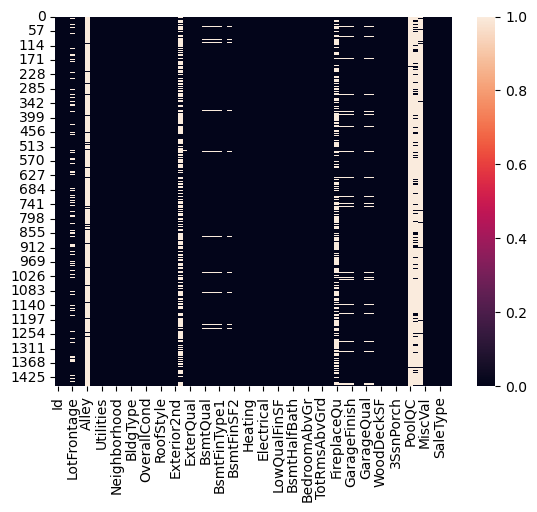

In [3]:
sns.heatmap(data.isnull())

Признаки, в которых пропущено более 30% данных, удалим

In [4]:
drop_cols = data.isnull().sum()[data.isnull().sum() > len(data)//3].index

data = data.drop(columns=drop_cols,axis=0)

Выделим количественные и категориальные признаки

In [5]:
num_cols = data.select_dtypes(exclude=['object']).columns
cat_cols = data.select_dtypes(include=['object']).columns

Заполним пропущенные значения для количественных признаков с помощью среднего, для категориальных с помощью медианы

In [6]:
data[num_cols] = data[num_cols].fillna(data[num_cols].median(axis=0))
data[cat_cols] = data[cat_cols].fillna(data[cat_cols].mode(axis=0).iloc[0])

Построим boxplot графики и посмотрим на выбросы

<Axes: >

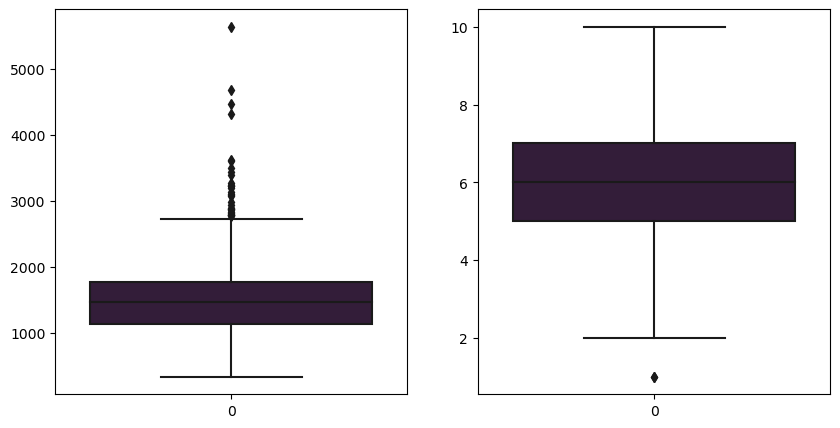

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.boxplot(data['GrLivArea'], ax=axes[0])
sns.boxplot(data['OverallQual'], ax=axes[1])

Удалим только сильные выбросы

In [8]:
data = data.sort_values(['GrLivArea'], ascending=False).reset_index().iloc[5:,:]
data = data.sort_values(['OverallQual'], ascending=True).reset_index().iloc[3:,:]
data_copy = data.copy()

Нормализуем данные с помощью MaxAbsScaler. Почему? Он не центрирует и не сдвигает наши данные относительно исходного их распределения, а также менее чувствителен к выбросам.

In [9]:
scaler = MaxAbsScaler()

data[num_cols] = scaler.fit_transform(data[num_cols])

In [10]:
data = pd.get_dummies(data, drop_first=True, dtype=int)

Возьмем только те признаки, которые имеют корреляцию с целевой переменной больше 0.7. Именно поэтому выше мы строили boxplot, только для этих признаков, так как перед нормализацией надо было удалить сильные выбросы.

In [11]:
corr_matrix = data.corr()

corr_matrix = corr_matrix['SalePrice']

corr_cols = corr_matrix[corr_matrix>0.7].index

data = data[corr_cols]

Создадим scaler-ы для обратного преобразования данных

In [12]:
scaler_corr_cols = MaxAbsScaler()
scaler_corr_cols.fit(data_copy[data.columns[:-1]])

scaler_SalePrice = MaxAbsScaler()
scaler_SalePrice.fit(np.array(data_copy.SalePrice).reshape(-1,1))

MaxAbsScaler()

`OverallQual`:  Общее качество материала и отделки  
`GrLivArea`: Жилая площадь, кв. футов  
  
Не смотря на то, что корреляция между ними 0.59, она вероятно обусловлена влиянием третьих переменных, поэтому можно сделать упрощающее предположение, что эти переменные независимы

<Axes: >

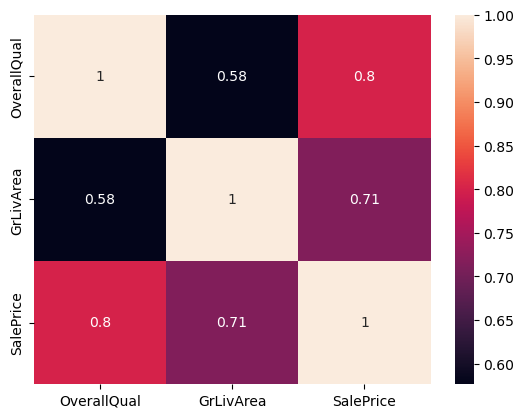

In [13]:
sns.heatmap(data.corr(),annot=True)

## Probabilistic modeling

<Axes: xlabel='OverallQual', ylabel='Count'>

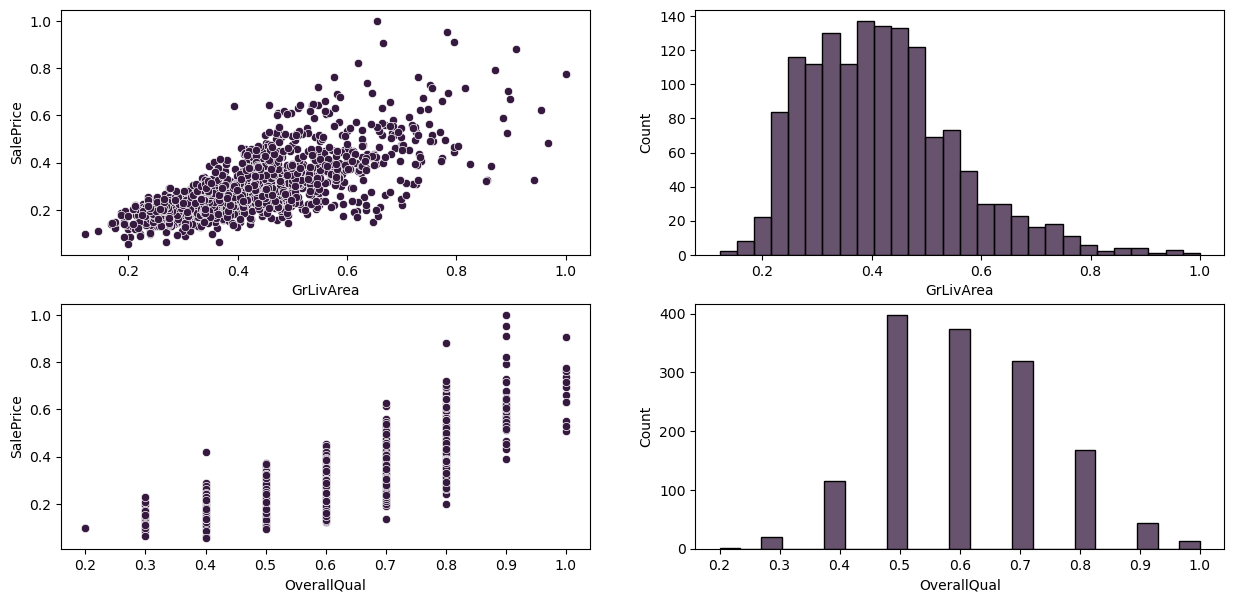

In [14]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,7))

sns.scatterplot(data, x='GrLivArea', y='SalePrice',ax=axes[0][0])
sns.histplot(data, x='GrLivArea',ax=axes[0][1])

sns.scatterplot(data, x='OverallQual', y='SalePrice', ax=axes[1][0])
sns.histplot(data, x='OverallQual', ax=axes[1][1])

<Axes: xlabel='SalePrice', ylabel='Count'>

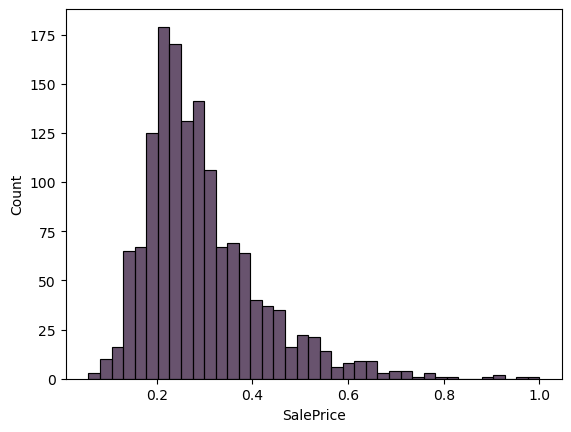

In [15]:
sns.histplot(data,x='SalePrice')

In [16]:
X = data.drop(columns=['SalePrice'], axis=0)
y = data.SalePrice

In [17]:
with pm.Model(coords={'obs_id': range(X.shape[0]), 'feature_id': range(X.shape[1])}) as model:
    x = pm.ConstantData('x', X, dims=('obs_id','feature_id'))

    sigma = pm.HalfNormal('sigma', sigma=1)

    beta0 = pm.Normal('beta0', mu=0, sigma=4)
    beta1 = pm.HalfNormal('GrLivArea', sigma=4)
    beta2 = pm.HalfNormal('OverallQual', sigma=4)

    mu = pm.Deterministic('mu', beta0 + beta1*x[:,1] + beta2*x[:,0], dims='obs_id')

    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    likelihood = pm.StudentT('y', nu=nu, mu=mu, sigma=sigma, observed=y, dims='obs_id')

    trace = pm.sample(draws=6000, tune=2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta0, GrLivArea, OverallQual, nu]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 77 seconds.


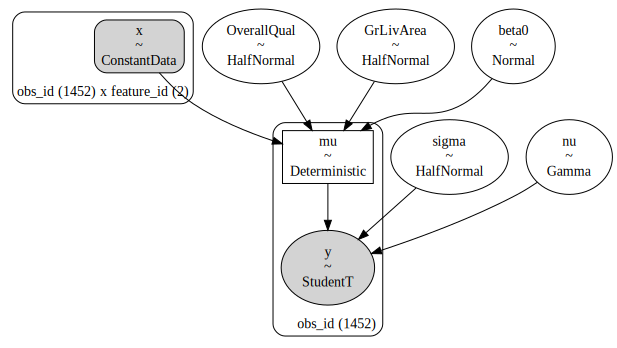

In [18]:
pm.model_to_graphviz(model)

Почему были выбраны такие prior-ы? Построим каждое из распределений и посмотрим на них.

Text(0.5, 1.0, 'Распределение Стьюдента')

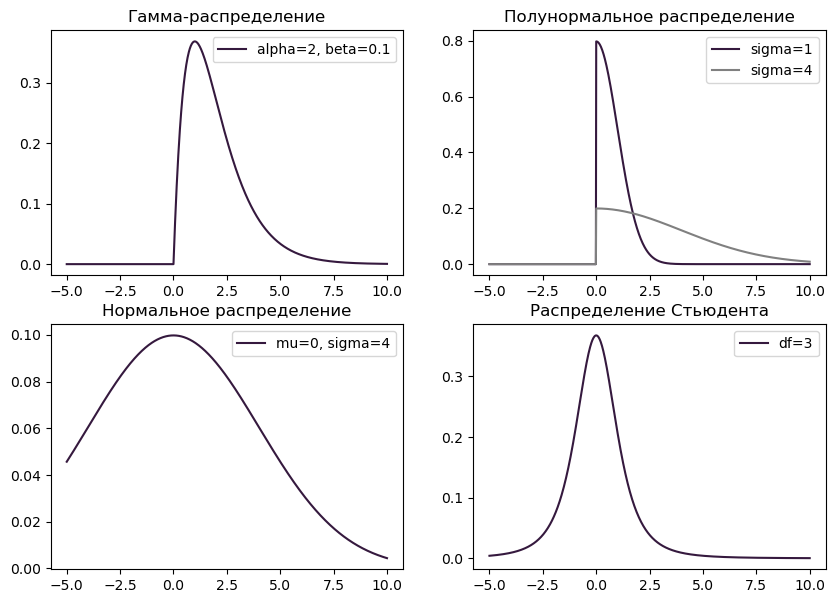

In [19]:
from scipy.stats import gamma, halfnorm, norm, t

# Диапазон значений для графика
x = np.linspace(-5, 10, 1000)

fig, axes = plt.subplots(2,2, figsize=(10,7))

# Гамма-распределение
pdf_gamma = gamma.pdf(x, a=2, scale=1)
axes[0][0].plot(x, pdf_gamma, label=f'alpha={2}, beta={0.1}')
axes[0][0].legend(loc='best')
axes[0][0].set_title('Гамма-распределение')

# Полунормальное распределение
pdf_halfnorm = halfnorm.pdf(x, scale=1)
axes[0][1].plot(x, pdf_halfnorm, label=f'sigma={1}')

pdf_halfnorm = halfnorm.pdf(x, scale=4)
axes[0][1].plot(x, pdf_halfnorm, label=f'sigma={4}', color='gray')
axes[0][1].legend(loc='best')
axes[0][1].set_title('Полунормальное распределение')

# Нормальное распределение
pdf_norm = norm.pdf(x, loc=0, scale=4)
axes[1][0].plot(x, pdf_norm, label=f'mu={0}, sigma={4}')
axes[1][0].legend(loc='best')
axes[1][0].set_title('Нормальное распределение')

# Распределение Стьюдента
pdf_t = t.pdf(x, df=3)
axes[1][1].plot(x, pdf_t, label=f'df={3}')
axes[1][1].legend(loc='best')
axes[1][1].set_title('Распределение Стьюдента')

Почему для параметра `nu` (степени свободы) было выбрано гамма распределение? Гамма распределение имеет значения строго больше 0, что важно для `nu`, а также перепробовал другие распределение, которые показывали результаты на метриках хуже. Почему параметры alpha=2, beta=0.1? Да, они довольно задают узкое распределение, но как показали эксперименты, задавая более узкое распределение, данные сами подкорректируют параметры, это будет лучше, чем мы сразу дадим более обширный выбор значений.  
  
Для коэффицентов `beta1`, `beta2` были выбраны полнунормальные распределения с sigma равной 4, так как в среднем с увеличением признаков, которые им принадлежат, увеличивается целевая переменная, а значит можно предположить, что это в основном положительная взаимосвязь. Почему sigma=4? Эксперименты показали, что лучше задать более широкое распределение, чтобы учитывать маловероятные значения. Отдельно для параметра `sigma`, которой характеризует разброс нашей целевой переменной, было выбрано также полунормальное с sigma=1, это показло наилучшие результаты по метрикам.  
  
Для коэффицента `beta0` было выбрано нормально распределение с параметрами mu=0 и sigma=4. Так нормальное распределение со средниим 0 подразумевает отрицательные значения, что для нас хорошо, так как это может скорректировать результат после `beta1`, `beta2`.

Для `likelihood` было выбрано распределение Стьюдента. Почему? Мы предполагаем что целевые данные распределены нормально с некоторым средним, но так как у нас могут быть выбросы, нужно распределение с более тяжелыми хвостами, чтобы учесть выбросы.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'GrLivArea'}>],
       [<Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallQual'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

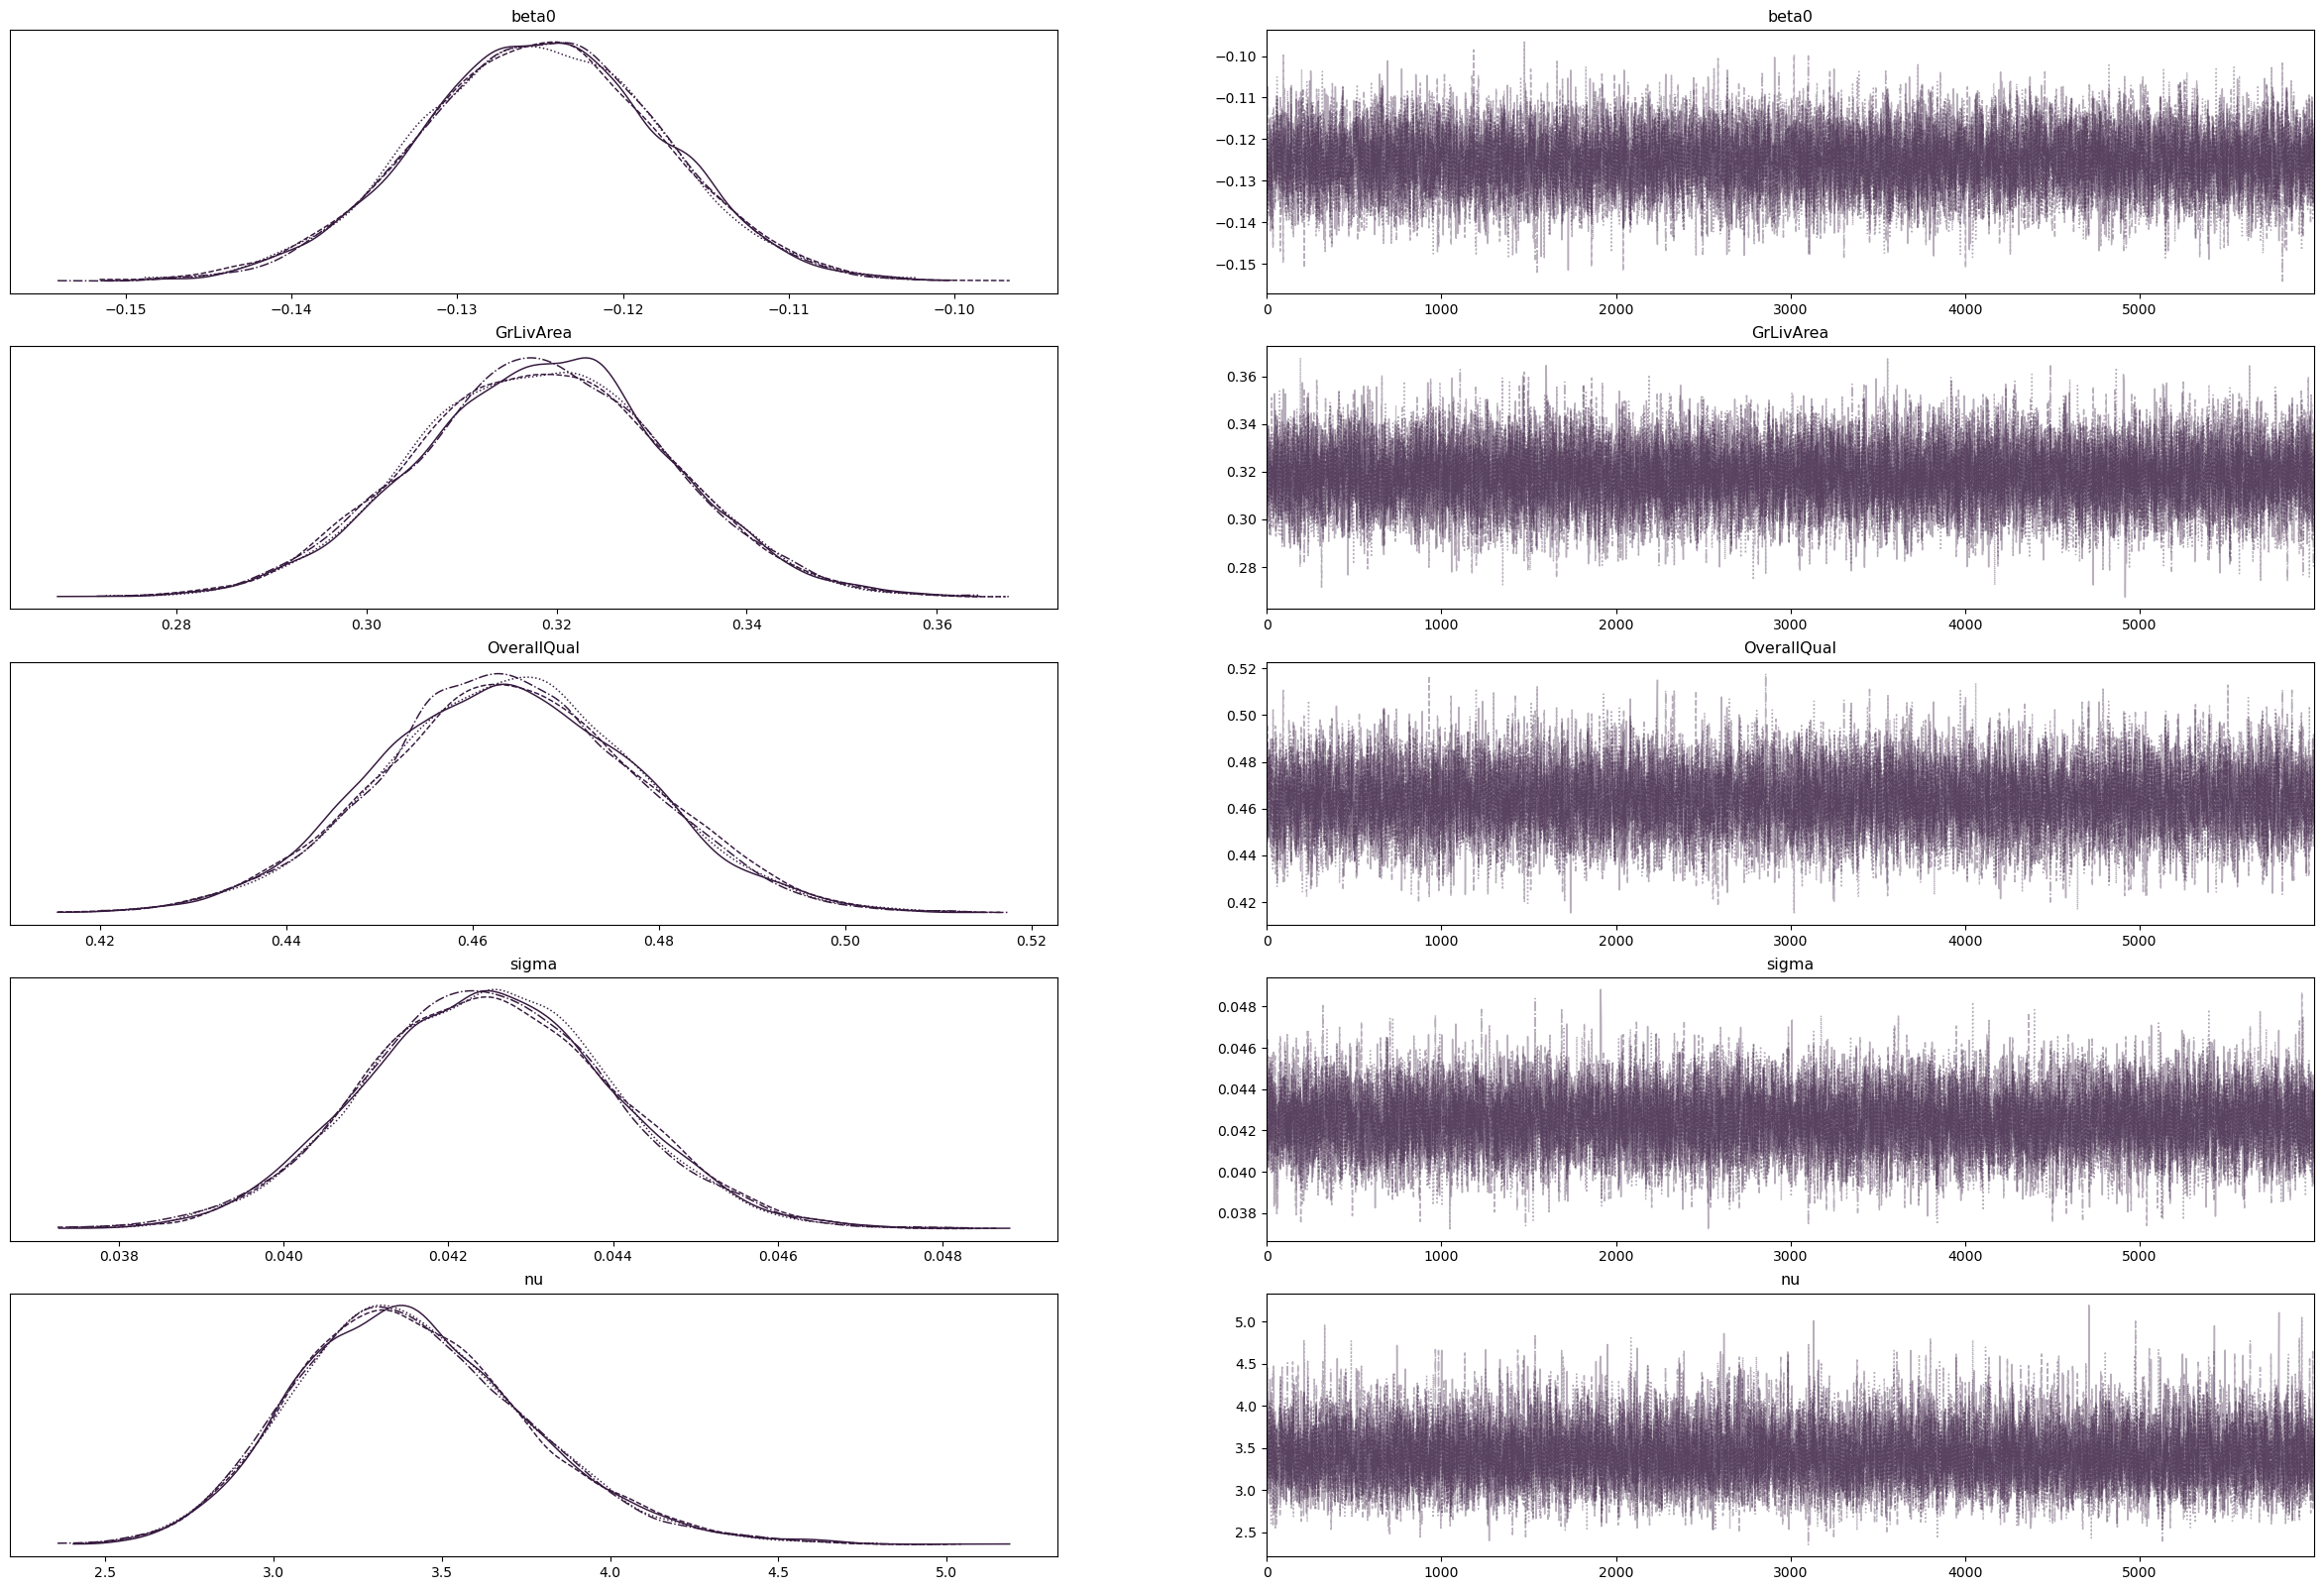

In [20]:
az.plot_trace(trace,var_names=['beta0','GrLivArea','OverallQual','sigma','nu'], figsize=(30,20))

C:\Users\Vasily\AppData\Local\Temp\ipykernel_13564\1795863269.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks, rotation=30)


<Figure size 640x480 with 0 Axes>

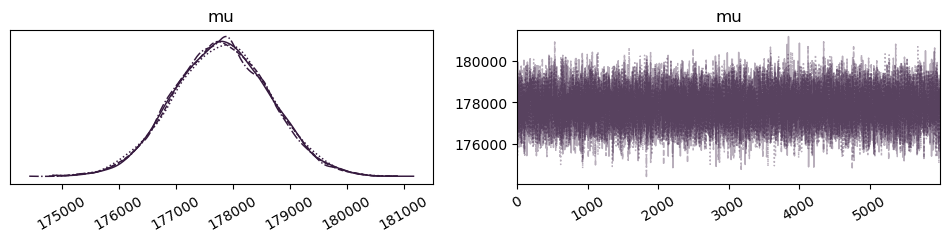

In [21]:
mean_mu = np.array([scaler_SalePrice.inverse_transform(vals.reshape(-1,1)) for vals in np.array(trace.posterior.mu.mean(axis=2))])

plt.figure()
axes = az.plot_trace(data=mean_mu)
for ax in axes.flatten():
    ticks = [int(tick) for tick in ax.get_xticks()]
    ax.set_xticklabels(ticks, rotation=30)
    ax.set_title('mu')

Построим наши плоскости и посмотрим, как в среднем они расположены относительно целевой переменной.

In [22]:
data_extract = az.extract(trace, num_samples=30)

In [24]:
surfaces = np.zeros((30,X.shape[0],X.shape[0]))
for i in range(30):
    surfaces[i] = (data_extract.beta0[i] +
        data_extract.GrLivArea[i]*xr.DataArray(X['GrLivArea']) +
        data_extract.OverallQual[i]*xr.DataArray(X['OverallQual']))

In [25]:
X_inv = scaler_corr_cols.inverse_transform(X)
y_inv = scaler_SalePrice.inverse_transform(np.array(y).reshape(-1,1))

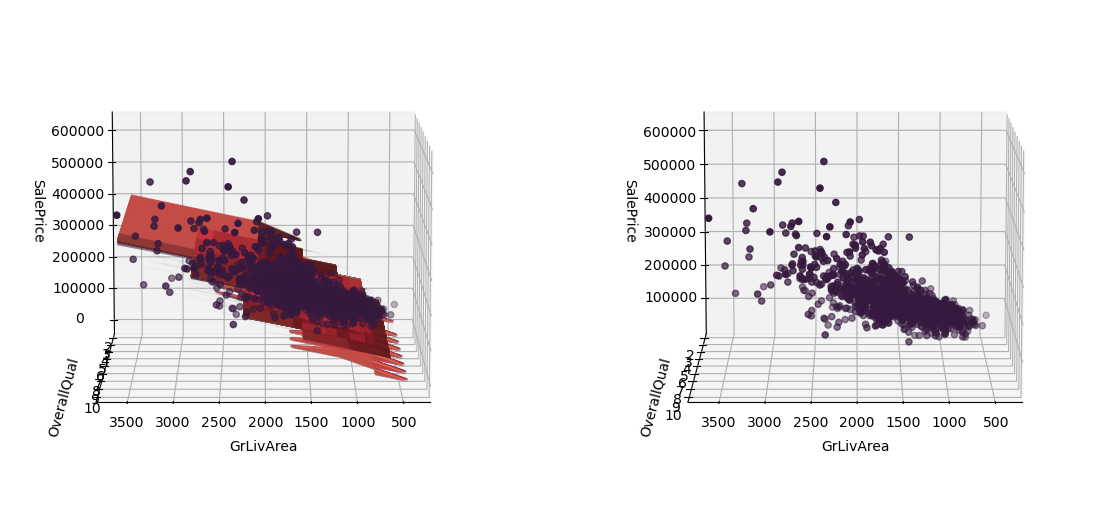

In [29]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(14,11), subplot_kw={'projection':'3d'})

GrLivArea_grid0, OverallQual_grid0 = np.meshgrid(X_inv[:,1], X_inv[:,0])
GrLivArea_grid1, OverallQual_grid1 = np.meshgrid(X['GrLivArea'], X['OverallQual'])

axes[0].scatter(X_inv[:,1],X_inv[:,0],y_inv)
axes[0].set_xlabel('GrLivArea')
axes[0].set_ylabel('OverallQual')
axes[0].set_zlabel('SalePrice', labelpad=30)
axes[0].xaxis.set_tick_params(pad=0)
axes[0].yaxis.set_tick_params(pad=-5)
axes[0].zaxis.set_tick_params(pad=15)

axes[1].scatter(X_inv[:,1],X_inv[:,0],y_inv)
axes[1].set_xlabel('GrLivArea')
axes[1].set_ylabel('OverallQual')
axes[1].set_zlabel('SalePrice', labelpad=30)
axes[1].xaxis.set_tick_params(pad=0)
axes[1].yaxis.set_tick_params(pad=1)
axes[1].zaxis.set_tick_params(pad=15)

axes[0].view_init(elev=10, azim=90)
axes[1].view_init(elev=10, azim=90)

for i in range(surfaces.shape[0]):
    surface = scaler_SalePrice.inverse_transform(surfaces[i])
    axes[0].plot_surface(GrLivArea_grid0, OverallQual_grid0, surface, alpha=0.5)

В среднем наше плоскости не притягиваются к выбросам. Итого, мы построили robust regression, модель которая хорошо устойчива к выбросам.

Найдем map (maximum aposterior probability)

In [30]:
with model:
    map_est = pm.find_MAP()

map_est

{'sigma_log__': array(-3.16580699),
 'beta0': array(-0.12450636),
 'GrLivArea_log__': array(-1.14586433),
 'OverallQual_log__': array(-0.76950323),
 'nu_log__': array(1.20310651),
 'sigma': array(0.04218009),
 'GrLivArea': array(0.31794899),
 'OverallQual': array(0.46324313),
 'nu': array(3.33044695),
 'mu': array([0.03864093, 0.00674029, 0.11871648, ..., 0.54424039, 0.59825999,
        0.65668576])}

Посмотрим на коэффиценты beta1, beta2, которые соответственно равны OverallQual=0.463, GrLivArea=0.3179. Наиболее вероятно, что качество материала и отделки больше влияет на цену дома чем жилая площадь. Также можно заметить, что дисперсия sigma=0.042 наиболее вероятно будет близка к нулю, но, конечно, могут быть такие дома, где цена не будет такой предсказуемой не смотря на признаки этого дома. Коэффицент beta0=-0.125 говорит о том, что, не смотря на положительную взаимосвязь beta1, beta2 с таргетом, он корректируют их, учитывая нетипичные данные, которые могут встретиться.

In [31]:
beta0_map = map_est['beta0']
beta1_map = map_est['GrLivArea']
beta2_map = map_est['OverallQual']

y_pred = beta0_map + beta1_map*X.iloc[:,1] + beta2_map*X.iloc[:,0]
y_pred = scaler_SalePrice.inverse_transform(np.array(y_pred).reshape(-1,1))

In [32]:
y_true = scaler_SalePrice.inverse_transform(np.array(y).reshape(-1,1))

Посчитаем метрику RMSE, по которой считаются сабмиты для этого датасета.

In [33]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_true,y_pred)**0.5

39507.88667313539